In [1]:
import os
os.symlink('/home/shared/cogneuro-connector/data/Week07_IntroFMRI_RawData/figures/','figures')

# Overview

## Introduction to functional magnetic resonance imaging (fMRI) - Part 2

In this session, we will continue working on the material from last week and learn about normalization and masking data.
In the second part of the class we will work with a visualization tool called [pycortex](http://gallantlab.org/pycortex/docs/).

# Goals for today

We will go over some important concepts of data manipulation and visualization in fMRI, including: 

* Normalize a timeseries
* Masking / unmasking of fMRI data

By the end, we will have written functions to:

* Mask and unmask an array
* Normalize a timeseries


## Short fMRI recap

Things to remember:

 - The functional signal we measure with fMRI is *not* an electrical neural signal (as in EEG, ECoG, or electrophysiology). It is a magnetic signal related to the properties of brain tissue, and it is dominated by blood flow. 
 - Blood flow is related to neural activity. 
     - Neural firing is metabolically demanding. 
     - Once region of the brain becomes active (once the neurons start firing), metabolism in that region is high and the neurons in that region need glucose. 
         - Glucose is not stored in the brain and needs to be transported to the active region whenever energy is needed. 
         - Glucose transported in red blood cells initiates a complex process to increase blood flow to the electrically active area bringing more oxygen into the region. 
         - When activity is high in a region oxygen gets stripped off of hemoglobin molecules in red blood cells(thereby changing the magnetic properties of hemoglobin, creating a deoxyhemoglobin). 
  - There are several ways to measure functional responses with MRI, and the specific one that we work with is the Blood Oxygenation Level Dependent Response, or the BOLD response. 

<img src="figures/deoxyhemoglobin.png" style="height: 400px;">


## FMRI activity in time

Once a neural event is triggered by a stimulus presentation the vascular system needs to respond to the need for glucose and oxygen in that specific brain area. This can take up to 1-2 seconds. Hence the hemodynamic response lags the triggered event by 1-2 seconds, which peaks around 5 seconds after the stimulus onset.

<img src="figures/lagged_activity.png" style="height: 400px;">

## Storing fMRI data for data analysis

We store fMRI data as a matrix. This means that each volume (a timepoint) in the experiment will correspond to a row in the matrix, and each voxel will correspond to a column in that matrix. For this reason, we need to make sure the criteria we use to move each 3D image to a matrix row is preserved and this operation is inverted. Let's look at an example.

<img src="figures/fmri_dimensions.png" style="height: 400px;">

## Loading data

In [2]:
import nibabel
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt  # for visualization

# Set defaults for matplotlib plotting in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In the following we will load one run (also referred to as a scan) worth of fMRI data that was stored as a nifti file format. 

In [3]:
# Create a nifti (nii) proxy object
fname = '/home/shared/cogneuro-connector/data/fmri/categories/sub01_categories1_1.nii.gz'
nii = nibabel.load(fname) 

# This object stores the infomation *about* the fMRI data stored in the file. 
# This meta-data can be accessed via attributes of the `nii` object.
print('nii.in_memory : ', nii.in_memory)
print('nii.shape : ', nii.shape)

nii.in_memory :  False
nii.shape :  (100, 100, 30, 120)


The dimensions of the data are (X, Y, Z, T) (T is time, in TRs). Thus, there are 120 volumes (120 time points). Each volume has 30 horizontal or transverse slices with 100 x 100 pixels.

<img src="figures/slices.png" style="height: 200px;">

In [4]:
# Retrieve actual data as an array
data = nii.get_data()
print('nii.in_memory : ', nii.in_memory)
print('data shape : ', data.shape)

nii.in_memory :  True
data shape :  (100, 100, 30, 120)


In [8]:
# Transpose data
data = data.T
print(data.shape)

(120, 30, 100, 100)


In [9]:
# We can select one volume like this: 
first_volume = data[0, :, :, :]

# Or like this: 
alt_first_volume1 = data[0, ...]

# Or like this: 
alt_first_volume2 = data[0]

# These are all the same1
assert np.all(first_volume==alt_first_volume1)
assert np.all(first_volume==alt_first_volume2)

In [10]:
print(first_volume.shape)

(30, 100, 100)


### Plot all horizontal slices

Let's try to make a plot with all of the horizontal slices, so we can see one entire 3D volume at once. For this, we will use the `subplot()` function in matplotlib:

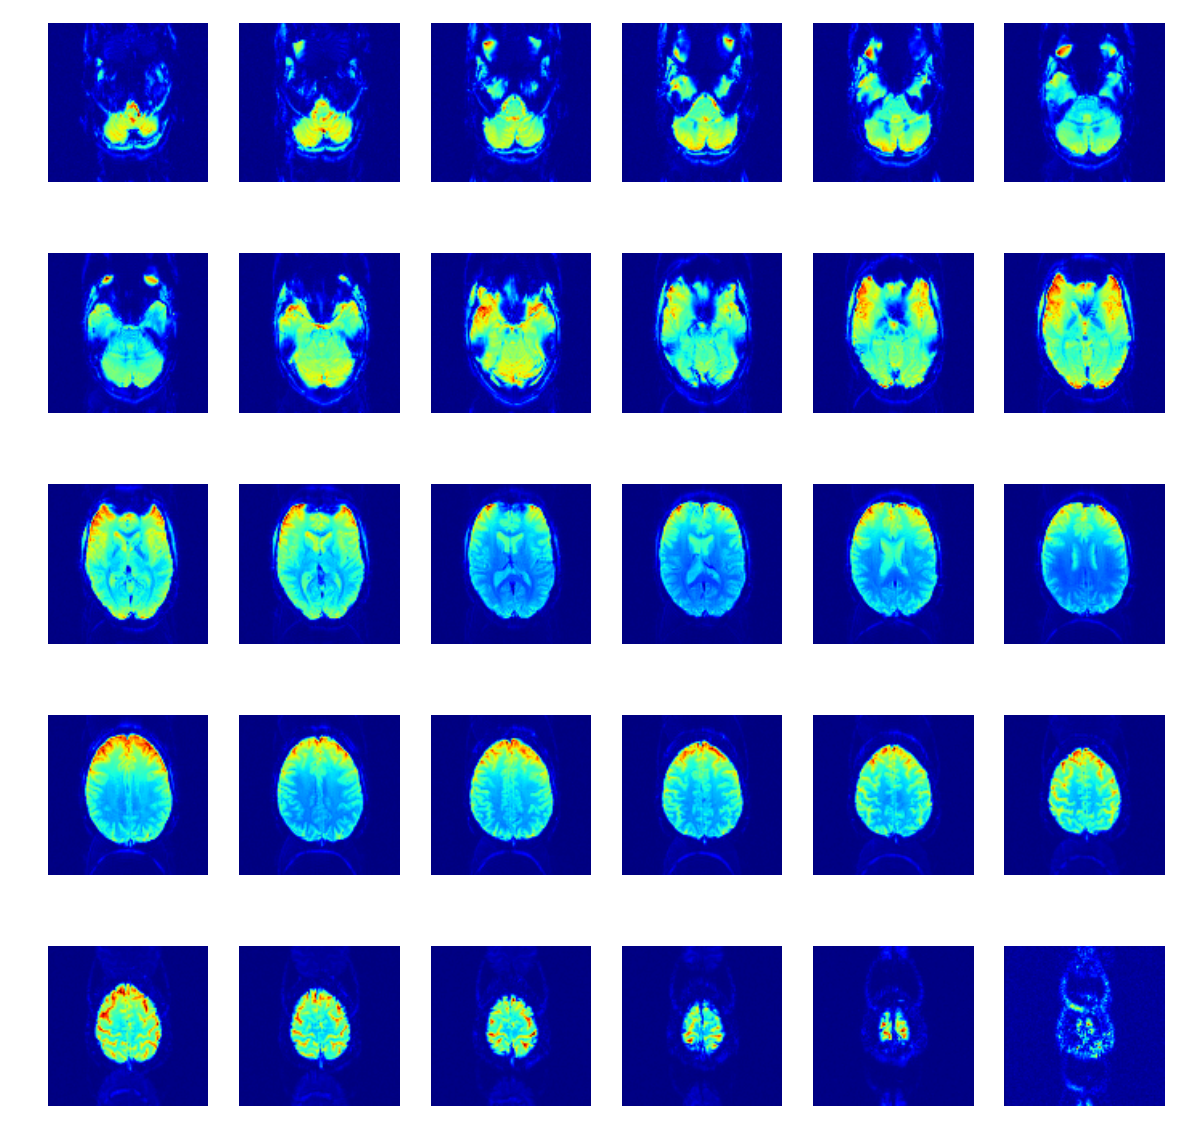

In [11]:
fig = plt.figure(figsize = (10,10))
n_slices = 30
nrows, ncols = 5, 6
for s in range(n_slices):
    ax = fig.add_subplot(nrows, ncols, s+1)
    slice_horizontal = first_volume[s,:,:]
    plt.imshow(slice_horizontal)
    ax.axis('off')

Now let's make a function that plots the above:

In [12]:
def plot_horizontal_slices(vol, **kwargs):
    fig = plt.figure(figsize=(10,10))
    nslices = vol.shape[0]
    subplot_size = np.ceil(np.sqrt(nslices))
    for s in range(nslices):
        ax = fig.add_subplot(subplot_size, subplot_size, s+1) 
        slice_horizontal = vol[s,:,:]
        plt.imshow(slice_horizontal, **kwargs)
        ax.axis('off')

## Masking

You may have noticed in the figure above that many of the voxels do not overlap with the brain (or more specifically the gray matter in the cortex) at all. Actually, let's try to plot some of those voxels:

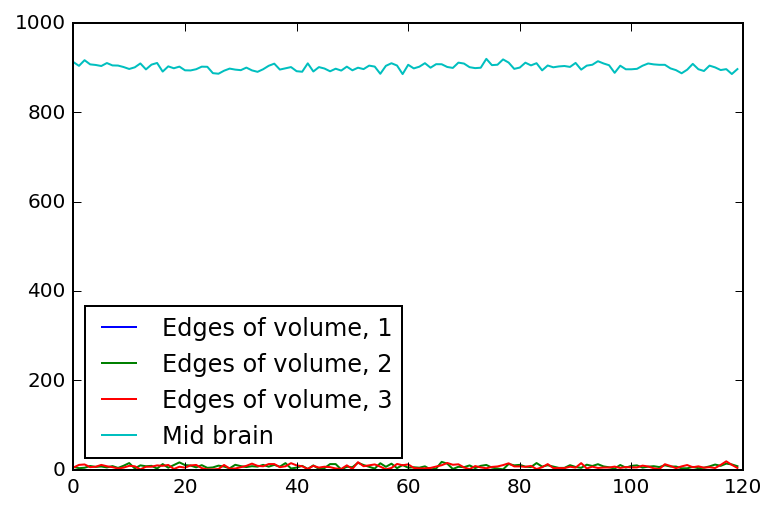

In [13]:
plt.plot(data[:,0,0,0], label='Edges of volume, 1')
plt.plot(data[:,1,1,1], label='Edges of volume, 2')
plt.plot(data[:,-1,-1,-1], label='Edges of volume, 3')

# A middle brain voxel
plt.plot(data[:,10,34,34], label='Mid brain')
plt.legend(loc='best')

The edge-of-scan voxels are clearly not in the brain, however, they show some variance due to noise. It is the practice in fMRI to mask out, or zero out these voxels.

A mask is a 3D binary array that is derived from the high resolution anatomical scan of the subject. The mask indicates, for every voxel in the 30 x 100 x 100 matrix, which ones should be ignored and which should be kept. Let's load and look at a voxel mask for this subject:

In [14]:
# Load a stored mask for this subject
fname = '/home/shared/cogneuro-connector/data/fmri/categories/s01_category_mask_cortical.npz'
mask = np.load(fname)['mask']
print('Mask shape: ', mask.shape)
print(mask[10,:,:])

FileNotFoundError: [Errno 2] No such file or directory: '/home/shared/cogneuro-connector/data/fmri/categories/s01_category_mask_cortical.npz'

Let's plot one fo the slices below:

In [ ]:
mask_horizontal = mask[15,:,:]
plt.imshow(mask_horizontal, origin='upper', cmap='gray')
_ = plt.axis("off")

We can see that the mask clearly indicates which voxels should be kept. 

### Breakout session: 
> Let's look at the 3D structure. Use the function we defined above to plot the entire 3D mask:

In [ ]:
### STUDENT ANSWER


You can see how now we have a mask that indicates which voxels we should keep and which we should exclude.

We can use the mask to set the tiny values outside the brain, and the values in the middle of the brain (in subcortical stuctures) to zero:

In [ ]:
# Let's plot the horizonral slices for the first volume
plot_horizontal_slices(first_volume)

In [ ]:
masked_vol_0 = first_volume * mask

# Now plot masked_vol_0:
plot_horizontal_slices(masked_vol_0)

You can see that the voxels outside the cortex (including in the middle of the brain) are zeroed out now! Let's apply this mask to the entire dataset now and zero out the same voxels in each volume:

In [ ]:
# First create an array with zeros
print(data.shape)
masked_data = np.zeros_like(data)

# NOTE: np.zeros_like is similar to creating an array using np.zeros. We can check this by:
assert np.all(np.zeros(data.shape)==np.zeros_like(data)) 

# Not run through the entire data set and mask each volume
for i in range(data.shape[0]):
    masked_data[i,:,:,:] = data[i,:,:,:] * mask

### Quick example for list comprehension

We can replace the above foor loop using list comprehension.

In general, list comprehension can be used to tranform a list to another list. During this process in the new list elements of the old list can be modified. List comprehensions can be used to replace many lines of code to a more compact one line. Every list comprehension can be written as a for loop. The opposite is not necessarly true.

We can basically use the same masking operation from the cell above and replace it by list comprehension. Let's see first how list comprehension works in a simple example:

In [ ]:
x = np.arange(5)
print('Input list: {}'.format(x))

# Let's create a for loop that squares each element in this list
# Afterwards, do the same using list comprehension 
# Compare the resulting arrays

### TEACHER INFO


Now we can use list comprehension to create the masked_data in a neat way:

In [ ]:
# Take individual volumes from data along the first dimension, and multiplies them by the mask
masked_data_v1 = [d*mask for d in data]  
print('masked_data_v1 is a {0} of size {1}'.format(type(masked_data_v1), len(masked_data_v1)))
print('each element is a {0} of size {1}'.format(type(masked_data_v1[0]), masked_data_v1[0].shape))
print('Type: {}, Shape: {}'.format(type(masked_data_v1), np.shape(masked_data_v1)))

Now let's try to combine them into an array, this is done as follows, and results in a 4 dimensional array. This stacks the data such as the first dimension is the one that is defined by the list:

In [ ]:
masked_data_v2 = np.array([d*mask for d in data])

print('masked_data_v2 is a {0} of size {1}'.format(type(masked_data_v2), masked_data_v2.shape))
print('each element is a {0} of size {1}'.format(type(masked_data_v2[0]), masked_data_v2[0].shape))
print('Type: {}, Shape: {}'.format(type(masked_data_v2), np.shape(masked_data_v2)))

### Breakout session:

> Now try plotting other volumes from masked_data_v2

In [ ]:
### STUDENT ANSWER


#### Logical indexing on the data array
You can see that there are many voxels that do not contain interesting information. Instead of storing each volume as a 3D array, we can instead take only the voxels that are in the mask.

We can use logical indexing to do this. Logical indexing can be used on any array:

In [ ]:
a = np.array([1, 2, 3, 4, 5])
idx = np.array([True, False, True, False, False])

In [ ]:
print(a[idx])

In [ ]:
# More examples: 2D
a = np.arange(20).reshape(5,4)
print(a)
idx = np.array([False, True, False, True])

In [ ]:
print(a[:, idx])

In [ ]:
first_volume = data[0]
print('shape of first_volume is {}'.format(first_volume.shape))

first_volume_masked = first_volume[mask==True]  # we can omit ==True, because mask is already a boolean array
print('shape of first_volume_masked is {}'.format(first_volume_masked.shape))

In [ ]:
_ = plt.hist(first_volume_masked.flatten(), 50)

Now we can compress the entire matrix:

In [ ]:
masked_data_v3 = data[:, mask]

print('masked_data_v3 is a {0} of size {1}'.format(type(masked_data_v3), masked_data_v3.shape))
print('each element is a {0} of size {1}'.format(type(masked_data_v3[0]), masked_data_v3[0].shape))

If we make another histogram of the masked (collapsed) data, we can see that we have a more interesting range of values left:

In [ ]:
_ = plt.hist(masked_data_v3.flatten(), 50)

We can easily go back and forth between the two formats, we need to have the mask and the 2D matrix to produce the 4D matrix:

In [ ]:
unmasked_data = np.zeros(data.shape)
unmasked_data[:, mask] = masked_data_v3 

print('unmasked_data is a {0} of size {1}'.format(type(unmasked_data), unmasked_data.shape))
print('each element is a {0} of size {1}'.format(type(unmasked_data[0]), unmasked_data[0].shape))

In [ ]:
_ = plt.hist(unmasked_data.flatten(), 50)


## Time series

Remember that one of these volumes is acquired at every time unit. The time unit here is 2.0045 seconds. Let's look at one slice at different time points. Now because masked_data_v3 only has cortical voxels, we can plot any of its dimension knowing that we are looking at gray matter.

In [ ]:
masked_data_v3.shape

### Breakout session: 
> Try to plot the activity in time for different voxels. What do you notice?

In [ ]:
### TEACHER INFO


Let's plot four different voxels time series

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(time_points, masked_data_v3[:n_points, 4].T)
plt.plot(time_points, masked_data_v3[:n_points, 10].T)
plt.plot(time_points, masked_data_v3[:n_points, 100].T)
plt.plot(time_points, masked_data_v3[:n_points, 1000].T)

_ = plt.xlabel("Time (s)")
_ = plt.ylabel("fMRI activity")

The voxels seem to have a different baseline! (You might have suspected this based on the image plots or the histogram plots above, too).

Let's plot one slice at different time points:

In [ ]:
fig = plt.figure(figsize = (10,10))
z_slice = 10
for s in range(15):
    ax = fig.add_subplot(5, 5, s+1)
    slice_horizontal = data[s, z_slice, :, :]
    slice_horizontal[~mask[z_slice, : , :]] = 0
    plt.imshow(slice_horizontal)
    plt.title('TR #{n}'.format(n=s+1))
    ax.axis('off')

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ax.imshow(masked_data_v3, aspect='auto')
# Set the axis labels using the `setp` method.
# http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.setp
plt.setp(ax, xlabel='Voxels', ylabel='Time')

### Normalize the activity at each voxel (zscore across time)

You can see the same effect in the time plots as well as in the mosaic plots: some voxels have a different baseline than others. 

We need to normalize the activity of each voxel in time to be able to see local fluctuations in the signal. This normalization is also called *z-score* or *standard score*.

1. We will first take the mean and standard deviation across time for each cortical voxel.
2. For each voxel, we will substract the mean from each time point.
3. For eacl voxel, we will divide each time point by the standard deviation.

In [ ]:
print(masked_data_v3.shape)
data_norm = masked_data_v3 - masked_data_v3.mean(axis = 0)
data_norm = data_norm / data_norm.std(axis = 0)

Now plot the time course:

In [ ]:
plt.figure(figsize = (10,5))
TR = 2.0045
points = range(0,100)
time_points = np.array(points)*TR

plt.plot(time_points, data_norm[:n_points, 4].T)
plt.plot(time_points, data_norm[:n_points, 10].T)
plt.plot(time_points, data_norm[:n_points, 100].T)
plt.plot(time_points, data_norm[:n_points, 1000].T)

_ = plt.xlabel("Time (s)")
_ = plt.ylabel("fMRI activity")

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
ax.imshow(data_norm, aspect='auto') 
plt.setp(ax, xlabel='Voxels', ylabel='Time')

And plot the volumes in time:

In [ ]:
data_norm_unmasked = np.zeros_like(data)
data_norm_unmasked[:,mask] = data_norm

In [ ]:
fig = plt.figure(figsize = (10,10))
for s in range(15):
    ax = fig.add_subplot(5,5,s+1)
    slice_horizontal = data_norm_unmasked[s,10,:,:]
    slice_horizontal[~mask[10,:,:]] = 0
    plt.imshow(slice_horizontal, vmin=-3, vmax=3) # don't forget vmin / vmax!
    ax.axis('off')

---